<a href="https://colab.research.google.com/github/xiaoshaoyc/CSCI-4962/blob/main/CSCI4962_HW1V2GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task1

We want to determine if a image is letter 1 or not.

Since we are trying to predict an category, we should use logistic 
regression to solve this problem.

In [ ]:
# we used GPU to accelerate the training
# please make sure the runtime has an available gpu('cuda:0')
# if you want to run it.
!nvidia-smi

Sat Sep 10 03:38:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    28W /  70W |   2262MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# init
import math
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import torchvision
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

# Task2
We used [MNIST](http://yann.lecun.com/exdb/mnist/) dataset.

The MNIST train dataset contains clean data, meaning there is **no missing data**. It contains 6742 images of letter $1$ and 53258 images of not letter $1$. Each image has a resolution of 28x28.
</br>
</br>
We can extract features from the images. However, it is also possible to use every pixel as a feature(so we have 784 features). In this case, **outliers** are impossible since every pixel has a data range from 0 to 255.
**Principal Component Analysis**, which is used to reduce the correlation of features, is also unnecessary because each pixel is independent. 
Nevertheless, we need to map the image sample from [0,255] to [0,1] to 
get a more stable outcome. 

In [ ]:
def transform1(x):
  # transformation for raw image data
  return torch.tensor(np.array(x).reshape(-1) / 255)

def y_trans(y):
  # transformation for label
  return (y == 1) * 1.0

# Here, we store all the data in memory to accelerate training
class Mem_dataset(torch.utils.data.Dataset):
  def __init__(self, dataset) -> None:
    super().__init__()
    self.cache = {}
    self.dataset = dataset

  def __getitem__(self, index):
    if index in self.cache:
      return self.cache[index]
    else:
      item = self.dataset[index]
      self.cache[index] = item
      return item

  def __len__(self):
    return len(self.dataset) 

In [ ]:
# fetch the dataset
train_dataset = torchvision.datasets.MNIST(root='', train=True, download=True, transform=transform1, target_transform=y_trans)

train_dataset_opt = Mem_dataset(train_dataset)

number of 1's = 6742
number of not 1's = 53258


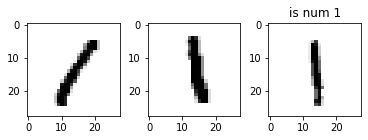

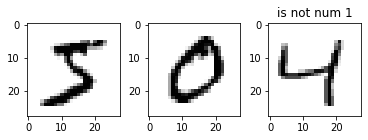

In [ ]:
# sample analyze
num1_list = list(filter(lambda x: x[1] == 1, train_dataset_opt))
not1_list = list(filter(lambda x: x[1] != 1, train_dataset_opt))

print(f'number of 1\'s = {len(num1_list)}')
print(f'number of not 1\'s = {len(not1_list)}')

fig, ax_list0 = plt.subplots(1, 3, figsize=(5, 10), constrained_layout=True)
ax_list0[0].imshow(num1_list[0][0].reshape(28, 28), cmap='binary')
ax_list0[1].imshow(num1_list[1][0].reshape(28, 28), cmap='binary')
ax_list0[2].imshow(num1_list[2][0].reshape(28, 28), cmap='binary')
plt.title('is num 1')
plt.show()

fig, ax_list1 = plt.subplots(1, 3, figsize=(5, 10), constrained_layout=True)
ax_list1[0].imshow(not1_list[0][0].reshape(28, 28), cmap='binary')
ax_list1[1].imshow(not1_list[1][0].reshape(28, 28), cmap='binary')
ax_list1[2].imshow(not1_list[2][0].reshape(28, 28), cmap='binary')
plt.title('is not num 1')
plt.show()

# Task 3
Our cost function is $c^{i}(y^{(i)},\hat{y}^{(i)})$ = $-(y^{(i)}\space log\hat{y}^{(i)} + (1-y^{i}) log(1-\hat{y}^{(i)}))$, where $\hat{y}^{i}$ is the predict output for image $i$.

We also have this cost for the entire data from `Lecture_2.pynb`
$$C(y,\hat{y}) = \frac{1}{n} \sum_{i=1}^{n} c^{i}(y^{(i)},\hat{y}^{(i)})$$

, and the derivative functions, where $X$ is the input, $A$ is the
predicted output, $Y$ is the ground truth.
$$ \frac{\partial L}{\partial w} = \frac{1}{n}X(A-Y)^T$$
$$ \frac{\partial L}{\partial b} = \frac{1}{n} \sum_{i=1}^n (a^{(i)}-y^{(i)})$$





In [ ]:
def draw_loss(loss_list, title):
  plt.plot(loss_list)
  plt.title(title)
  plt.xlabel('epoch')
  plt.ylabel('loss')
  last_x = len(loss_list) - 1
  last_y = loss_list[-1]
  plt.text(last_x*0.95, last_y*1.1, f'{last_y:.4}')


In [ ]:
SMALL_CONSTANT = 0
def cost_fn(y, y_pred):
  return -1/len(y)*torch.sum(
      y * torch.log(y_pred + SMALL_CONSTANT)
      + (1-y) * torch.log(1-y_pred - SMALL_CONSTANT)
      )

def deriv_fn(x, y, y_pred):
  dw = (x.T @ (y_pred-y)) / len(y)
  db = torch.sum(y_pred-y) / len(y)
  return dw, db

def sigmoid(x):
  return 1 / (1 + torch.exp(-x))


class vanilla:
  def __init__(self, lr) -> None:
    self.lr = lr

  def update(self, w, dw, b, db):
    w = w - self.lr * dw
    b = b - self.lr * db
    return w, b

In [ ]:
GPU = torch.device('cuda:0')

In [ ]:
# init weights
shape = train_dataset[0][0].shape
W = torch.zeros(shape, dtype=torch.double).reshape(-1, 1).to(GPU)
B = 0

In [ ]:
optimizer = vanilla(0.001)

preparing data
start training for 50 epoch


loss=0.48030028055839197: 100%|██████████| 50/50 [00:10<00:00,  4.73it/s]


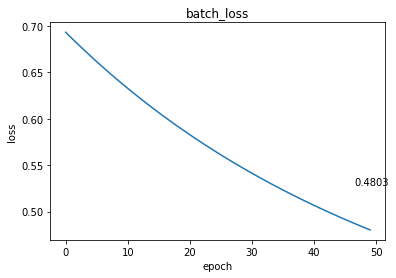

In [ ]:
# batch gradient descent
@torch.no_grad()
def train_vanilla(epoch, W, B, optimizer):
  cost_list = []
  cost = None
  print('preparing data')
  image_list, label_list = zip(*train_dataset)
  print(f'start training for {epoch} epoch')
  pbar = tqdm(range(epoch))
  for i in pbar:
    image = torch.stack(image_list).to(GPU)
    label = torch.tensor(label_list).reshape(-1, 1).to(GPU)
    y_pred = sigmoid(image @ W + B)

    cost = cost_fn(label, y_pred).item()
    if math.isinf(cost):
      cost = 0xFFFF

    dw, db = deriv_fn(image, label, y_pred)
    W, B = optimizer.update(W, dw, B, db)

    pbar.set_description(f'loss={cost}')
    cost_list.append(cost)

  return cost_list

optimizer = vanilla(0.001)
batch_loss_list = train_vanilla(50, W, B, optimizer)
draw_loss(batch_loss_list, 'batch_loss')

In [ ]:
# stochastic gradient descent
import random

CPU = torch.device('cpu') # IO too slow on gpu...

@torch.no_grad()
def train_vanilla(epoch, W, B, optimizer):
  W = W.to(CPU)

  cost_list = []
  cost = None
  print('preparing data')
  t_dataset = list(train_dataset)
  print(f'start training for {epoch} epoch')
  pbar = tqdm(range(epoch))
  for i in pbar:
    total_cost = 0
    random.shuffle(t_dataset) # shuffle

    for sample in t_dataset:
      image = [sample[0]]
      label = [sample[1]]

      image = torch.stack(image).to(CPU)
      label = torch.tensor(label).reshape(-1, 1).to(CPU)
      y_pred = sigmoid(image @ W + B)

      cost = cost_fn(label, y_pred).item()
      if math.isinf(cost):
        cost = 0xFFFF

      dw, db = deriv_fn(image, label, y_pred)
      W, B = optimizer.update(W, dw, B, db)
      total_cost += cost

    total_cost /= len(train_dataset)
    pbar.set_description(f'loss={total_cost}')
    cost_list.append(total_cost)

  return cost_list

optimizer = vanilla(0.001)
stochastic_loss = train_vanilla(50, W, B, optimizer)
draw_loss(stochastic_loss, 'stochastic_loss')

preparing data
start training for 50 epoch


loss=0.026622752298596883: 100%|██████████| 50/50 [10:50<00:00, 13.00s/it]


preparing data
start training for 50 epoch


loss=0.27573493754895795: 100%|██████████| 50/50 [00:17<00:00,  2.90it/s]


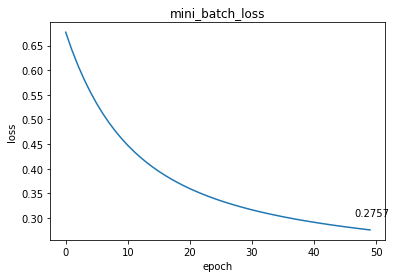

In [ ]:
# mini-batch gradient descent
import random

@torch.no_grad()
def train_vanilla(epoch, W, B, optimizer):
  batch_size = 10000

  cost_list = []
  cost = None
  print('preparing data')
  t_dataset = list(train_dataset)
  print(f'start training for {epoch} epoch')
  pbar = tqdm(range(epoch))
  for i in pbar:
    index = 0
    total_cost = 0
    random.shuffle(t_dataset) # shuffle

    while index < len(t_dataset):
      end = min(index+batch_size, len(t_dataset))
      image, label = zip(*t_dataset[index:end])

      image = torch.stack(image).to(GPU)
      label = torch.tensor(label).reshape(-1, 1).to(GPU)
      y_pred = sigmoid(image @ W + B)

      cost = cost_fn(label, y_pred).item()
      if math.isinf(cost):
        cost = 0xFFFF

      dw, db = deriv_fn(image, label, y_pred)
      W, B = optimizer.update(W, dw, B, db)
      total_cost += cost

      # go to next mini-batch
      index += batch_size

    total_cost /= (len(t_dataset) // batch_size)
    pbar.set_description(f'loss={total_cost}')
    cost_list.append(total_cost)
  
  return cost_list


optimizer = vanilla(0.001)
mini_batch_loss = train_vanilla(50, W, B, optimizer)
draw_loss(mini_batch_loss, 'mini_batch_loss')

# Task 4
We will use `Adam` and `Rmsprop` to optimize the 'vanilla' gradient descent.

In [ ]:
class Adam:
  def __init__(self, lr, betas, eps) -> None:
    self.m = 0
    self.v = 0
    self.m_b = 0
    self.v_b = 0
    self.lr = lr
    self.b1, self.b2 = betas
    self.eps = eps

  def update(self, w, dw, b, db):
    self.m = self.b1 * self.m + (1-self.b1) * dw
    self.v = self.b2 * self.v + (1-self.b2) * (dw ** 2)
    self.m_b = self.b1 * self.m_b + (1-self.b1) * b
    self.v_b = self.b2 * self.v_b + (1-self.b2) * (db ** 2)
    m_hat = self.m / (1 - self.b1)
    v_hat = self.v / (1 - self.b2)
    m_hat_b = self.m_b / (1 - self.b1)
    v_hat_b = self.v_b / (1 - self.b2)
    return (
        w - self.lr / (torch.sqrt(v_hat) + self.eps) * m_hat,
        b - self.lr / (torch.sqrt(v_hat_b) + self.eps) * m_hat_b
    ) 


class Rmsprop:
  def __init__(self, lr, alpha=0.9, eps=1e-8) -> None:
    self.prev_w = 0
    self.prev_b = 0
    self.lr = lr
    self.alpha = alpha
    self.eps = eps

  def update(self, w, dw, b, db):
    new_w = self.alpha * self.prev_w + (1-self.alpha) * (dw ** 2)
    self.prev_w = new_w
    new_b = self.alpha * self.prev_b + (1-self.alpha) * (db ** 2)
    self.prev_b = new_b
    return (
        w - self.lr / torch.sqrt(new_w + self.eps) * dw,
        b - self.lr / torch.sqrt(new_b + self.eps) * db
    ) 

preparing data
start training for 50 epoch


loss=0.17479341421512515: 100%|██████████| 50/50 [00:10<00:00,  4.65it/s]


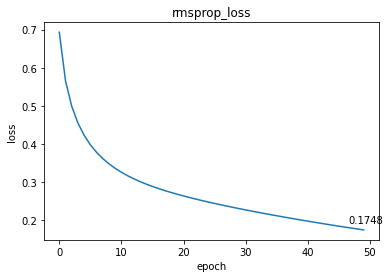

In [ ]:
# Rmsprop
@torch.no_grad()
def train(epoch, W, B, optimizer):
  W = W.to(GPU)

  cost_list = []
  cost = None
  print('preparing data')
  image_list, label_list = zip(*train_dataset_opt)
  print(f'start training for {epoch} epoch')
  pbar = tqdm(range(epoch))
  for i in pbar:
    image = torch.stack(image_list).to(GPU)
    label = torch.tensor(label_list).reshape(-1, 1).to(GPU)
    y_pred = sigmoid(image @ W + B)

    cost = cost_fn(label, y_pred).item()
    if math.isinf(cost):
      cost = 0xFFFF

    dw, db = deriv_fn(image, label, y_pred)
    W, B = optimizer.update(W, dw, B, db)

    pbar.set_description(f'loss={cost}')
    cost_list.append(cost)

  return cost_list

optimizer = Rmsprop(0.001)
rmsprop_loss_list = train(50, W, B, optimizer)
draw_loss(rmsprop_loss_list, 'rmsprop_loss')

preparing data
start training for 50 epoch


loss=0.16923103424634423: 100%|██████████| 50/50 [00:10<00:00,  4.63it/s]


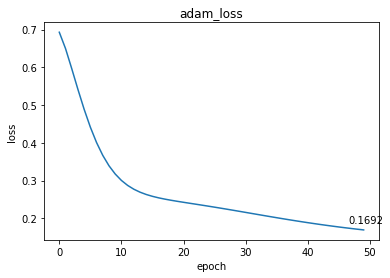

In [ ]:
# Adam
optimizer = Adam(0.001, (0.9, 0.999), 1e-08)
adam_loss_list = train(50, W, B, optimizer)
draw_loss(adam_loss_list, 'adam_loss')

preparing data
start training for 50 epoch


loss=0.48030028055839197: 100%|██████████| 50/50 [00:10<00:00,  4.67it/s]


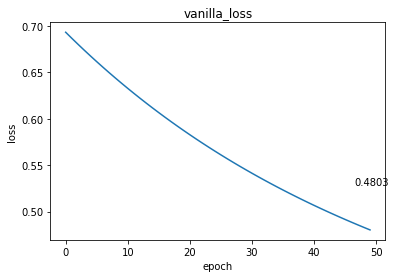

In [ ]:
# vanilla
optimizer = vanilla(0.001)
vanilla_loss_list = train(50, W, B, optimizer)
draw_loss(vanilla_loss_list, 'vanilla_loss')

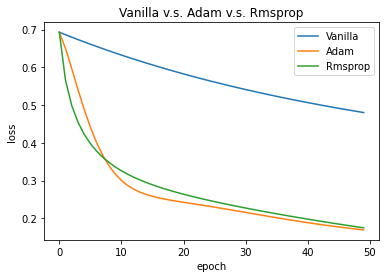

In [ ]:
# compare different algorithm
plt.plot(vanilla_loss_list, label='Vanilla')
plt.plot(adam_loss_list, label='Adam')
plt.plot(rmsprop_loss_list, label='Rmsprop')
plt.title('Vanilla v.s. Adam v.s. Rmsprop')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

We used each of Vanilla, Adam, and Rmsprop to train our model for 50 epoches. The Vanilla algorithm reaches an in-sample err of `0.480`; the Adam algorithm achieved an in-sample error of `0.169`; the Rmsprop algorithm had an in-sample error of `0.175`. We should use the advanced optimization algorithm since it gives a boost to our learning speed, and the model will converge faster.

# TEST

preparing data
start training for 500 epoch


loss=0.05902452903341372: 100%|██████████| 500/500 [01:48<00:00,  4.60it/s]


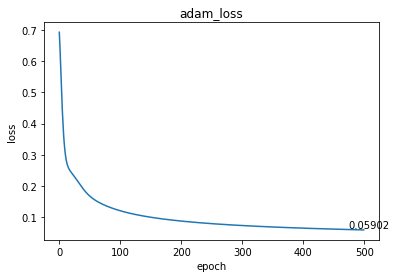

In [ ]:
# Adam
optimizer = Adam(0.001, (0.9, 0.999), 1e-08)
adam_loss_list = train(500, W, B, optimizer)
draw_loss(adam_loss_list, 'adam_loss')